# Introduction


This code presents a training of the pre-trained Faster R-CNN-ResNet-FPN model using torchvision to work with computer vision in the pytorch framework for single-class object detection (in the case of the pen detection dataset used). The dataset was taken from the [roboflow](https://universe.roboflow.com/zainab-aldhanhani/pen-nsayu/dataset/1) resource. The dataset is a csv file with data such as training image locations, image dimensions (width, height), class markup (class name), and bounding box coordinates.

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Data Preprocessing Pipeline

Creating a class for converting raw images to tensors, also for other image transformations

Due to the peculiarities of the training dataset, in order to avoid errors in the process of model training, it is necessary to execute code from the directory ../train/

In [8]:
%cd '.../pendataset/train'

/kaggle/input/pendataset/train


A class for converting a raw dataset into a tensors for model training with some input image transformations 

In [26]:
class CustomDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.data = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
    return len(self.data)

# The second index indicates the number of the dataset column (starting from zero), 
# where the corresponding information is located 
  def __getitem__(self, idx):
    image_path = self.data.iloc[idx, 0]
    class_name = self.data.iloc[idx, 3]
    class_idx = class_name2idx_dict[class_name]
    xmin = self.data.iloc[idx, 4]
    ymin = self.data.iloc[idx, 5]
    xmax = self.data.iloc[idx, 6]
    ymax = self.data.iloc[idx, 7]

    image = Image.open(image_path).convert("RGB")
    target = {"boxes": torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
                  "labels": torch.tensor([class_idx], dtype=torch.int64)}  # Assuming only one class (num_classes=1)
    
    if self.transform:
      image = self.transform(image)

    return image, target

In [27]:
import torchvision.transforms as T

# a function for image transformations
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [28]:
# Training dataset path
DATASET_PATH = '_annotations.csv'

In [29]:
# Creating a dictionary of class name and index correspondence
class_names = pd.read_csv(DATASET_PATH).iloc[:, 3]

class_names = set(class_names)
idx2class_name_dict = {i+1 : name for i, name in enumerate(class_names)} # by the zero index the model denotes the background
class_name2idx_dict = {v : k for k, v in idx2class_name_dict.items()}

In [30]:
# Loading and preprocessing a training dataset
dataset = CustomDataset(DATASET_PATH, transform=get_transform(train=True))
print(f"Length of the Dataset: {len(dataset)}")
# Creating a data loader for a model
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

Length of the Dataset: 49


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Visualization of a sample training sample

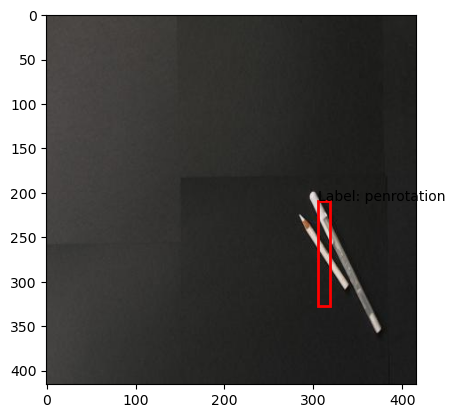

In [31]:
from random import randint

ds = pd.read_csv(DATASET_PATH)
rand_ds_el = randint(0, len(dataset)-1)

xmin, ymin, xmax, ymax = ds.iloc[rand_ds_el, [4, 5, 6, 7]]
image_path = ds.iloc[rand_ds_el, 0]
label = ds.iloc[rand_ds_el, 3]

image = Image.open(image_path).convert("RGB")

plt.imshow(image)
ax = plt.gca()

rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
ax.add_patch(rect)
ax.text(xmin, ymin, f"Label: {label}")

plt.show()

# Model Selection Pipeline

In [33]:
# Loading a pre-trained model Faster R-CNN-ResNet50-FPN
model = fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Freeze a certain number of model layers equal to the value of the num_layers_to_freeze variable. 
# The rest are used for fine-tining

NUM_LAYERS_TO_FREEZE = 60
f_l = 0
nml = 0
for param in model.parameters():
    if f_l < NUM_LAYERS_TO_FREEZE:
        param.requires_grad = False
        f_l += 1
        nml += 1
    else:
        param.requires_grad = True
        nml += 1
print(f"Frozen layers: {f_l} out of {nml}")

Frozen layers: 60 out of 83


In [35]:
# Replacing the last layers for the desired number of classes (1 + background)
NUM_CLASSES = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

In [ ]:
# Weights loadings for this model
model.load_state_dict(torch.load('.../model_weights/model_weights.pth'))

In [36]:
# Defining the optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

In [37]:
# Moving the model on the CUDA architecture (GPU)
# If there is no such a possibility, we use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Model Fine-tuning

In [38]:
NUM_EPOCHS = 2000
# Switching the model to training mode for model training
model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for images, targets in data_loader:
        images = images.to(device)
#       bring the batch created by DataLoader into the right form for feeding into the model 
        targets = [{"boxes" : batch_boxes.to(device), "labels" : targets['labels'][i].to(device)} for i, batch_boxes in enumerate(targets["boxes"])]
        
        optimizer.zero_grad()

        outputs = model(images, targets)

        # Total model loss
        loss = outputs['loss_classifier'] + outputs['loss_box_reg'] + outputs['loss_objectness'] + outputs['loss_rpn_box_reg']
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # Average loss per epoch
    epoch_loss = running_loss / len(data_loader)
#     torch.save(model.state_dict(), 'directory/to/save/model_weights.pth') # saving weights after each epoch 
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/2000], Loss: 2.2812
Epoch [2/2000], Loss: 0.9071
Epoch [3/2000], Loss: 0.2827
Epoch [4/2000], Loss: 0.3237
Epoch [5/2000], Loss: 0.2138
Epoch [6/2000], Loss: 0.2329
Epoch [7/2000], Loss: 0.1734
Epoch [8/2000], Loss: 0.2048
Epoch [9/2000], Loss: 0.2012
Epoch [10/2000], Loss: 0.1765
Epoch [11/2000], Loss: 0.1764
Epoch [12/2000], Loss: 0.2119
Epoch [13/2000], Loss: 0.2271
Epoch [14/2000], Loss: 0.1674
Epoch [15/2000], Loss: 0.1896
Epoch [16/2000], Loss: 0.2177
Epoch [17/2000], Loss: 0.2682
Epoch [18/2000], Loss: 0.1780
Epoch [19/2000], Loss: 0.1809
Epoch [20/2000], Loss: 0.1818
Epoch [21/2000], Loss: 0.1894
Epoch [22/2000], Loss: 0.1843
Epoch [23/2000], Loss: 0.2198
Epoch [24/2000], Loss: 0.2088
Epoch [25/2000], Loss: 0.1615
Epoch [26/2000], Loss: 0.2024
Epoch [27/2000], Loss: 0.2084
Epoch [28/2000], Loss: 0.1911
Epoch [29/2000], Loss: 0.1820
Epoch [30/2000], Loss: 0.1635
Epoch [31/2000], Loss: 0.1763
Epoch [32/2000], Loss: 0.3823
Epoch [33/2000], Loss: 0.1948
Epoch [34/2000], Lo

KeyboardInterrupt: 

In [39]:
# saving model weights
torch.save(model.state_dict(), '.../model_weights/model_weights.pth')

# Test Model

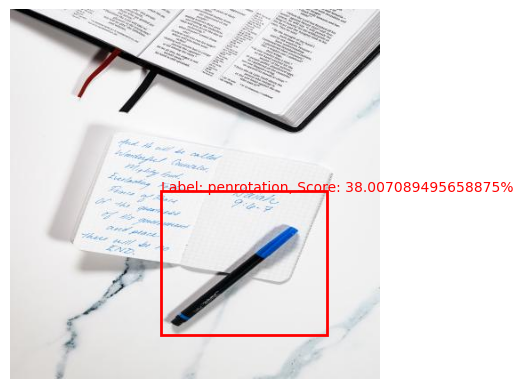

In [43]:
# Switching the model to evaluation mode for inference
model.eval()
# Test Image Path
image_path = '.../pendataset/test/nathan-dumlao-j-qaWWJ9e0o-unsplash_jpg.rf.b1978dcf7385f86790ee06a0beae3c08.jpg'

image = Image.open(image_path).convert("RGB")

transform = get_transform(train=False)
# Image to Tensor
image_tensor = transform(image)

image_tensor = image_tensor.to(device)

with torch.no_grad():
    predictions = model([image_tensor])

# Getting predicted bounding boxes and class labels
boxes = predictions[0]["boxes"].detach().cpu().numpy()
labels = predictions[0]["labels"].detach().cpu().numpy()
scores = predictions[0]["scores"].detach().cpu().numpy()

# Threshold for discarding results with low model confidence
threshold = 0.3
filtered_indices = np.where(scores >= threshold)[0]
filtered_boxes = boxes[filtered_indices]
filtered_labels = labels[filtered_indices]
filtered_scores = scores[filtered_indices]
# Threshold for discarding frequently overlapping results
nms_threshold = 0.3
keep_indices = torchvision.ops.nms(torch.tensor(filtered_boxes), torch.tensor(scores[filtered_indices]), nms_threshold)
filtered_boxes = filtered_boxes[keep_indices]
filtered_labels = filtered_labels[keep_indices]
filtered_scores = filtered_scores[filtered_indices]

if isinstance(filtered_labels, np.int64):
  filtered_labels = [filtered_labels]
  filtered_boxes = [filtered_boxes]
  filtered_scores = [filtered_scores]
  

plt.imshow(image)
ax = plt.gca()
# Visualization of bounding boxes on the test image
for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
    xmin, ymin, xmax, ymax = box
    label = idx2class_name_dict[label.item()]
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(xmin, ymin, f"Label: {label}, Score: {score.item()*100}%", color="r")

plt.axis("off")
plt.show()